## Выполнил: Соковнин Игорь

# Спортивный анализ данных. Платформа Kaggle

## Урок 3. Построение надежных схем валидации решения, оптимизация целевых метрик

### Домашнее задание:

**Основное задание:**

Даны выборки для обучения и для тестирования.
Задание заключается в том, чтобы попробовать разные способы валидации, проанализировать плюсы / минусы каждой и сделать выводы о том,  какой способ валидации наиболее устойчивый в данной задаче.

Метрика качества для оценки прогнозов - **ROC-AUC**, название целевой переменной - **IsFraud**.

Рекомендуется использовать модели градиетного бустинга, реализация любая / гипепараметры любые.

    Внимание!
    Выборка assignment_2_test.csv - наш аналог лидерборда. Будем моделировать ситуацию отправки решения на лидерборд 
    и сравнить значение метрики на лидерборде и на локальной валидации. Для других целей использовать выборку запрещено!.
   

**Терминалогия, используемая в задании**:
* ***обучающая выборка*** - выборка, которая передается в метод fit/train;
* ***валидационная выборка*** - выборка, которая получается при Hold-Out на 2 выборки (train, valid);
* ***тестовая выборка*** - выборка, которая получается при Hold-Out на 3 выборки (train, valid, test);
* ***ЛБ*** - лидерборд, выборка assignment_2_test.csv.

Ссылка на данные - https://drive.google.com/file/d/1gMEVl47pIoV1-AseB9doQ6DZNJrY3NkW/view?usp=sharing

**[Задание 1](#task1):** сделать Hold-Out валидацию с разбиением, размер которого будет адеквтаным, по вашему мнению.
 Разбиение проводить по id-транзакции (TransactionID), обучать модель градиетного бустинга любой реализации с подбором числа деревьев по early_stopping критерию до достижения сходимости.
 Оценить качество модели на валидационной выборке, оценить расхождение по сравнению с качеством на обучающей выборке и валидационной выборке.
 Оценить качество на ЛБ, сравнить с качеством на обучении и валидации. Сделать выводы.

**[Задание 2](#task2):** сделать Hold-Out валидацию с разбиением на 3 выборки, разбиение проводить по id-транзакции (TransactionID), размер каждой выборки подобрать самостоятельно. Повторить процедуру из п.1. для каждой выборки.

**[Задание 3](#task3):** построить доверительный интервал на данных из п.2 на основе бутстреп выборок, оценить качество модели на ЛБ относительно полученного доверительного интервала. Сделать выводы.

**[Задание 4](#task4):** выполнить Adversarial Validation, подобрать объекты из обучающей выборки, которые сильно похожи на объекты из assignment_2_test.csv, и использовать их в качестве валидационного набора. Оценить качество модели на ЛБ, сделать выводы о полученных результатах.

**[Задание 5](#task5):** сделать KFold / StratifiedKFold валидацию (на ваше усмотрение), оценить получаемые качество и разброс по метрике качества. Сделать выводы об устойчивости кросс-валидации, сходимости оценки на кросс-валидации и отложенном наборе данных. Оценить качество на ЛБ, сделать выводы.

## Подключение библиотек и скриптов

In [1]:
import warnings
import numpy as np
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Модель
import catboost as cb
# Метрика
from sklearn.metrics import roc_auc_score, auc
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score

warnings.simplefilter("ignore")
%matplotlib inline

In [2]:
# разварачиваем выходной дисплей, чтобы увидеть больше столбцов и строк a pandas DataFrame
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
def reduce_mem_usage(df):
    '''Сокращение размера датафрейма за счёт изменения типа данных'''
    
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [4]:
# !dir

In [5]:
# input
TRAIN_DATASET_PATH = '../../data/assignment_2_train.csv'
TEST_DATASET_PATH = '../../data/assignment_2_test.csv'

## Загрузка данных

In [6]:
# Тренировочные данные
# train = pd.read_csv(TRAIN_DATASET_PATH, header = none)  # если надо скрыть названия столбцов
train = pd.read_csv(TRAIN_DATASET_PATH)
df_train =reduce_mem_usage(train)  # Уменьшаем размер данныхM
df_train.head(2)

Memory usage of dataframe is 541.08 MB
Memory usage after optimization is: 262.48 MB
Decreased by 51.5%


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [7]:
# Тестовые данные
leaderboard = pd.read_csv(TEST_DATASET_PATH)
df_leaderboard =reduce_mem_usage(leaderboard)  # Уменьшаем размер данных

df_leaderboard.head(2)

Memory usage of dataframe is 300.60 MB
Memory usage after optimization is: 145.83 MB
Decreased by 51.5%


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,3287000,1,7415038,226.0,W,12473,555.0,150.0,visa,226.0,credit,299.0,87.0,116.0,NaN,aol.com,NaN,2.0,3.0,0.0,0.0,0.0,5.0,0.0,0.0,3.0,0.0,3.0,2.0,6.0,2.0,4.0,4.0,0.0,4.0,3.0,NaN,NaN,NaN,NaN,4.0,4.0,NaN,NaN,NaN,3.0,T,T,F,M0,T,F,F,F,T,1.0,2.0,2.0,1.0,3.0,1.0,1.0,1.0,2.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,2.0,5.0,0.0,0.0,1.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,2.0,0.0,0.0,0.0,1.0,1.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,2.0,5.0,0.0,0.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,7.0,7.0,0.0,1.0,1.0,2.0,6.0,6.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,452.0,1482.0,1482.0,0.0,206.0,206.0,452.0,1276.0,1276.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,14.0,7.0,9.0,15.0,0.0,2.0,0.0,2.0,1.0,2.0,1.0,2.0,2.0,2.0,12.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,452.000000,2924.000000,2924.000000,0.0,412.0,0.0,412.0,206.0,412.0,412.0,452.0,2512.0,2512.0,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3287001,0,7415054,3072.0,W,15651,417.0,150.0,visa,226.0,debit,330.0,87.0,NaN,NaN,yahoo.com,NaN,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0

__Числовых признаки__

In [118]:
numerical_features = df_train.select_dtypes(exclude=["category"])
numerical_features = numerical_features.columns.tolist()

__Обрабатка категориальные признаков__

In [9]:
catigorical_features = [
'ProductCD',  # 180000 non-null  category
'card4',  # 179992 non-null  category
'card6',  # 179993 non-null  category
'P_emaildomain',  # 151560 non-null  category
'R_emaildomain',  # 60300 non-null   category
'M1',  # 61749 non-null   category
'M2',  # 61749 non-null   category
'M3',  # 61749 non-null   category
'M4',  # 83276 non-null   category
'M5',  # 61703 non-null   category
'M6',  # 105652 non-null  category
'M7',  # 31652 non-null   category
'M8',  # 31652 non-null   category
'M9'  # 31652 non-null   category
]

### Подготовка тренировочных данных

In [11]:
data = []
data = df_train[numerical_features + catigorical_features]

# заполняем пропуски в категориалиных признаках
for feature in catigorical_features:
    data[feature] = data[feature].cat.add_categories('Unknown')
    data[feature].fillna('Unknown', inplace =True) 
    
# Каждой категории сопоставляет целое число (номер категории) - https://dyakonov.org/2016/08/03/python-категориальные-признаки/
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
for cat_colname in data[catigorical_features].columns:
    le.fit(data[cat_colname])
    data[cat_colname+'_le'] = le.transform(data[cat_colname])

# target = df_train["isFraud"]

In [12]:
df_train_new = data
df_train_new = df_train_new.drop(catigorical_features, axis=1)
# df_train_new.columns

In [13]:
# df_train_new.head(2)

### Подготовка ЛБ (лидерборд) данных 

In [14]:
data = []
data = df_leaderboard[numerical_features + catigorical_features]

# заполняем пропуски в категориалиных признаках
for feature in catigorical_features:
    data[feature] = data[feature].cat.add_categories('Unknown')
    data[feature].fillna('Unknown', inplace =True) 
    
# Каждой категории сопоставляет целое число (номер категории) - https://dyakonov.org/2016/08/03/python-категориальные-признаки/
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
for cat_colname in data[catigorical_features].columns:
    le.fit(data[cat_colname])
    data[cat_colname+'_le'] = le.transform(data[cat_colname])

y_leaderboard = df_leaderboard["isFraud"]

In [15]:
x_leaderboard = data
x_leaderboard = x_leaderboard.drop(catigorical_features, axis=1)

x_leaderboard = x_leaderboard.drop(["TransactionID", "isFraud"], axis=1)

In [16]:
catigorical_features_name = ['ProductCD_le', 'card4_le', 'card6_le', 'R_emaildomain_le',
                      'M1_le', 'M2_le', 'M3_le', 'M4_le', 'M5_le', 'M6_le', 'M7_le', 'M8_le', 'M9_le']

## Задание 1:<a class="anchor" id="task1"></a>

Cделать __Hold-Out__ валидацию с разбиением, размер которого будет адекватным, по вашему мнению. Разбиение проводить по __id__-транзакции (__TransactionID__), обучать модель градиетного бустинга любой реализации с подбором числа деревьев по __early_stopping__ критерию до достижения сходимости. Оценить качество модели на валидационной выборке, оценить расхождение по сравнению с качеством на обучающей выборке и валидационной выборке. Оценить качество на ЛБ, сравнить с качеством на обучении и валидации. Сделать выводы.

__Hold-Out разбиение__

In [17]:
x_train, x_test = train_test_split(
    df_train_new.drop(["TransactionID", "isFraud"], axis=1), train_size=0.70, shuffle=True, random_state=1,
)

y_train, y_test = train_test_split(
    df_train_new["isFraud"], train_size=0.70, shuffle=True, random_state=1,
)

In [18]:
x_train.head(2)
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 125999 entries, 59549 to 128037
Columns: 392 entries, TransactionDT to M9_le
dtypes: float32(376), int16(1), int32(15)
memory usage: 189.1 MB


In [19]:
x_test.head(2)
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 125999 entries, 59549 to 128037
Columns: 392 entries, TransactionDT to M9_le
dtypes: float32(376), int16(1), int32(15)
memory usage: 189.1 MB


In [20]:
print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_test.shape = {} rows, {} cols".format(*x_test.shape))

x_train.shape = 125999 rows, 392 cols
x_test.shape = 54001 rows, 392 cols


In [21]:
print(y_train.shape)
print(y_test.shape)

(125999,)
(54001,)


__XGBoost__

In [22]:
import xgboost as xgb
from sklearn.metrics import r2_score

#model = xgb.XGBRegressor(random_state=1)
#model.fit(x_train, y_train)

In [23]:
#train_score = r2_score(y_train, model.predict(x_train))
#test_score = r2_score(y_test, model.predict(x_test))

#print(f"Train-score: {round(train_score, 3)}, Test-score: {round(test_score, 3)}")

### LightGBM Sklearn-API

In [24]:
import lightgbm as lgb

#from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [25]:
"""params = {
    "boosting_type": "gbdt",  # gradient boosting tree decision tree (бустинг над решающими деревьями)
    "objective": "binary",
    #"metric": "auc", # метрика качества - ROC AUC
    "metric":"None",
    "learning_rate": 0.01,  # скорсть обучения
    "n_estimators": 10000,  # число деревьев
    # регуляризация
    "n_jobs": 6,
    "seed": 27
}"""

'params = {\n    "boosting_type": "gbdt",  # gradient boosting tree decision tree (бустинг над решающими деревьями)\n    "objective": "binary",\n    #"metric": "auc", # метрика качества - ROC AUC\n    "metric":"None",\n    "learning_rate": 0.01,  # скорсть обучения\n    "n_estimators": 10000,  # число деревьев\n    # регуляризация\n    "n_jobs": 6,\n    "seed": 27\n}'

In [57]:
# Задача бинарной классификации
params = {
    "boosting_type": "gbdt",  # gradient boosting tree decision tree (бустинг над решающими деревьями)
    "objective": "binary",
    "metric": "auc", # метрика качества - ROC AUC
    "learning_rate": 0.01,  # скорсть обучения
    "n_estimators": 20000,  # число деревьев
     # регуляризация
    "reg_lambda": 100,  # регуляризация (то что используется при F2-штрафе (1:15:10))
    "max_depth": 4,  # глубина дерева
    #"gamma": 10,  # min-е улучшение функции потерь при котором мы будем делать разбиени (1:15:40)
    #"nthread": 6, # число ядер
    "n_jobs": 6,
    "seed": 27
}

In [27]:
# Оценить качество модели на валидационной выборке, оценить расхождение
# по сравнению с качеством на обучающей выборке и валидационной выборке.
model = lgb.LGBMClassifier(**params)
model.fit(
    X=x_train,
    y=y_train,
    eval_set=[(x_train, y_train), (x_test, y_test)],
    categorical_feature = catigorical_features_name,
    early_stopping_rounds=25,
    eval_metric="auc",
    verbose=500
)

[LightGBM] [Warning] Unknown parameter: gamma
Training until validation scores don't improve for 25 rounds
[500]	training's auc: 0.90193	valid_1's auc: 0.892426
[1000]	training's auc: 0.915824	valid_1's auc: 0.902881
[1500]	training's auc: 0.923122	valid_1's auc: 0.908277
[2000]	training's auc: 0.928314	valid_1's auc: 0.912221
[2500]	training's auc: 0.93248	valid_1's auc: 0.915232
[3000]	training's auc: 0.936058	valid_1's auc: 0.917712
[3500]	training's auc: 0.938812	valid_1's auc: 0.919346
[4000]	training's auc: 0.941278	valid_1's auc: 0.920767
[4500]	training's auc: 0.943461	valid_1's auc: 0.922273
[5000]	training's auc: 0.945636	valid_1's auc: 0.923682
[5500]	training's auc: 0.947323	valid_1's auc: 0.924723
[6000]	training's auc: 0.949253	valid_1's auc: 0.925867
[6500]	training's auc: 0.950772	valid_1's auc: 0.926758
[7000]	training's auc: 0.952319	valid_1's auc: 0.927659
[7500]	training's auc: 0.954209	valid_1's auc: 0.928775
[8000]	training's auc: 0.955837	valid_1's auc: 0.929767


LGBMClassifier(gamma=10, learning_rate=0.01, max_depth=4, metric='auc',
               n_estimators=20000, n_jobs=6, objective='binary', reg_lambda=100,
               seed=27)

In [28]:
#x_train.head(2)

In [29]:
#y_train

### Оценка качества модели

In [30]:
train_score = roc_auc_score(y_train, model.predict(x_train))
test_score = roc_auc_score(y_test, model.predict(x_test))
leaderboard_score = roc_auc_score(y_leaderboard, model.predict(x_leaderboard))

print(f'train_score={train_score}')
print(f'test_score={test_score}')
print(f'leaderboard_score={leaderboard_score}')

train_score=0.7688092681395586
test_score=0.737555057193122
leaderboard_score=0.6156232360519123


### Результат:
    train_size = 0.70 (разбиение данных на 70% (train) и 30% (test))

    train_score=0.7688092681395586 - Качество на обучении
    test_score=0.737555057193122 - Качество на тесте
    leaderboard_score=0.6156232360519123 - Качество на ЛБ


### Вывод:


Разница __$\Delta$__ между обучением (train_score)  и валидационной выборкой (test_score):

- __$\Delta_{0.7}$ = train_score - test_score = 0.7688092681395586 - 0.737555057193122 = 0.031254210946436656 ~ 0.03__

Разница __$\Delta$__ между обучением (train_score)  и ЛБ (leaderboard_score):

- __$\Delta_{0.7}$ = train_score - leaderboard_score = 0.737555057193122 - 0.6156232360519123 = 0.1219318211412097 ~ 0.12__

__$\Delta$__ между обучением и валидационной выборкой,  __$\Delta_{0.7}$__ = 0.031254210946436656 ~ 3% (< 5%) от значения ROC AUC тренировочной выборки.

__$\Delta$__ между обучением и ЛБ,  __$\Delta_{0.7}$__ = 0.1219318211412097 ~ 12% (> 10%) от значения ROC AUC тренировочной выборки.

Следовательно: 
- *распределения на обучающей выборке и валидационной выборкой близки друг другу - модель обучена хорошо*;
- *распределения на обучающей выборке и ЛБ значительно отличаются между собой*.

In [31]:
0.7688092681395586 - 0.737555057193122
0.737555057193122 - 0.6156232360519123


0.1219318211412097

## Задание 2:<a class="anchor" id="task2"></a>


Сделать Hold-Out валидацию с разбиением на 3 выборки, разбиение проводить по id-транзакции (TransactionID), размер каждой выборки подобрать самостоятельно. Повторить процедуру из п.1. для каждой выборки.

In [32]:
x_train, x_valid = train_test_split(
    df_train_new.drop(["TransactionID", "isFraud"], axis=1), train_size=0.70, shuffle=True, random_state=1,
)
y_train, y_valid = train_test_split(
    df_train_new["isFraud"], train_size=0.70, shuffle=True, random_state=1,
)

x_valid, x_test = train_test_split(
    x_valid, train_size=0.7, shuffle=True, random_state=27
)
y_valid, y_test = train_test_split(
    y_valid, train_size=0.7, shuffle=True, random_state=27
)

print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))
print("x_test.shape = {} rows, {} cols".format(*x_test.shape))

x_train.shape = 125999 rows, 392 cols
x_valid.shape = 37800 rows, 392 cols
x_test.shape = 16201 rows, 392 cols


In [33]:
# Оценить качество модели на валидационной выборке, оценить расхождение
# по сравнению с качеством на обучающей выборке и валидационной выборке.
model_1 = lgb.LGBMClassifier(**params)
model_1.fit(
    X=x_train,  # используем обработанный датафрэйм из предыдущего занятия
    y=y_train,
    eval_set=[(x_train, y_train), (x_valid, y_valid)],
    categorical_feature = catigorical_features_name,
    early_stopping_rounds=25,
    eval_metric="auc",
    verbose=500
)

[LightGBM] [Warning] Unknown parameter: gamma
Training until validation scores don't improve for 25 rounds
[500]	training's auc: 0.90193	valid_1's auc: 0.896502
[1000]	training's auc: 0.915824	valid_1's auc: 0.906843
[1500]	training's auc: 0.923122	valid_1's auc: 0.911853
[2000]	training's auc: 0.928314	valid_1's auc: 0.915473
[2500]	training's auc: 0.93248	valid_1's auc: 0.918239
[3000]	training's auc: 0.936058	valid_1's auc: 0.920355
[3500]	training's auc: 0.938812	valid_1's auc: 0.921745
[4000]	training's auc: 0.941278	valid_1's auc: 0.923011
[4500]	training's auc: 0.943461	valid_1's auc: 0.924294
[5000]	training's auc: 0.945636	valid_1's auc: 0.925551
[5500]	training's auc: 0.947323	valid_1's auc: 0.926388
[6000]	training's auc: 0.949253	valid_1's auc: 0.927516
[6500]	training's auc: 0.950772	valid_1's auc: 0.928302
[7000]	training's auc: 0.952319	valid_1's auc: 0.929226
[7500]	training's auc: 0.954209	valid_1's auc: 0.930246
[8000]	training's auc: 0.955837	valid_1's auc: 0.931039


LGBMClassifier(gamma=10, learning_rate=0.01, max_depth=4, metric='auc',
               n_estimators=20000, n_jobs=6, objective='binary', reg_lambda=100,
               seed=27)

### Оценка качества модели

In [34]:
train_score = roc_auc_score(y_train, model_1.predict(x_train))
valid_score = roc_auc_score(y_valid, model_1.predict(x_valid))
test_score = roc_auc_score(y_test, model_1.predict(x_test))
leaderboard_score = roc_auc_score(y_leaderboard, model_1.predict(x_leaderboard))

print(f'train_score={train_score}')
print(f'valid_score={valid_score}')
print(f'test_score={test_score}')
print(f'leaderboard_score={leaderboard_score}')

train_score=0.759251168407984
valid_score=0.7330467583957665
test_score=0.7316095612084162
leaderboard_score=0.6161438007400407


### Результат:
    train_size = 0.70 (разбиение данных на 70% (train), 20% (valid) и 10% (test))
    
    train_score=0.759251168407984 - Качество на обучении
    valid_score=0.7330467583957665 - Качество на валидации
    test_score=0.7316095612084162 - Качество на тесте
    leaderboard_score=0.6161438007400407 - Качество на ЛБ

### Вывод:


Разница __$\Delta$__ между обучением (train_score)  и валидационной выборкой (test_score):

- __$\Delta_{0.7}$ = train_score - test_score__ = 0.759251168407984 - 0.7330467583957665 = 0.026204410012217516 ~ 0.03

Разница __$\Delta$__ между обучением (train_score)  и тестом (test_score):

- __$\Delta_{0.7}$ = train_score - leaderboard_score__ = 0.759251168407984 - 0.7316095612084162 = 0.027641607199567764 ~ 0.03

Разница __$\Delta$__ между обучением (train_score)  и ЛБ (leaderboard_score):

- __$\Delta_{0.7}$ = train_score - leaderboard_score__ = 0.759251168407984 - 0.6161438007400407 = 0.1431073676679433 ~ 0.143

__$\Delta$__ между train и valid:  __$\Delta_{0.7}$__ = 0.026204410012217516, что ~ 3% (< 10%) от значения ROC AUC тренировочной выборки.

__$\Delta$__ между train и test:  __$\Delta_{0.7}$__ = 0.027641607199567764, что ~ 3% (< 10%) от значения ROC AUC тренировочной выборки.

__$\Delta$__ между train и ЛБ:  __$\Delta_{0.7}$__ = 0.1431073676679433, что ~ 14.3% (> 10%) от значения ROC AUC тренировочной выборки.


In [35]:
0.759251168407984 - 0.7330467583957665
0.759251168407984 - 0.7316095612084162
0.759251168407984 - 0.6161438007400407

0.1431073676679433

## Задание 3:<a class="anchor" id="task3"></a>

Построить доверительный интервал на данных из п.2 на основе бутстреп выборок, оценить качество модели на ЛБ относительно полученного доверительного интервала. Сделать выводы.

## Bootstrap

In [36]:
from tqdm import tqdm
from typing import List, Tuple

#from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score

In [37]:
def create_bootstrap_samples(data: np.array, n_samples: int = 10000) -> np.array:
    """
    Создание бутстреп-выборок.

    Parameters
    ----------
    data: np.array
        Исходная выборка, которая будет использоваться для
        создания бутстреп выборок.

    n_samples: int, optional, default = 10000
        Количество создаваемых бутстреп выборок.
        Опциональный параметр, по умолчанию, равен 10000.

    Returns
    -------
    bootstrap_idx: np.array
        Матрица индексов, для создания бутстреп выборок.

    """
    bootstrap_idx = np.random.randint(
        low=0, high=len(data), size=(n_samples, len(data))
    )
    return bootstrap_idx


def create_bootstrap_metrics(y_true: np.array,
                             y_pred: np.array,
                             metric: callable,
                             n_samlpes: int = 10000) -> List[float]:
    """
    Вычисление бутстреп оценок.

    Parameters
    ----------
    y_true: np.array
        Вектор целевой переменной.

    y_pred: np.array
        Вектор прогнозов.

    metric: callable
        Функция для вычисления метрики.
        Функция должна принимать 2 аргумента: y_true, y_pred.

    n_samples: int, optional, default = 10000
        Количество создаваемых бутстреп выборок.
        Опциональный параметр, по умолчанию, равен 10000.

    Returns
    -------
    bootstrap_metrics: List[float]
        Список со значениями метрики качества на каждой бустреп выборке.
        (оценки метрика качества на каждой бутстреп выборке)

    """
    scores = []

    if isinstance(y_true, pd.Series):
        y_true = y_true.values

    bootstrap_idx = create_bootstrap_samples(y_true)  # генерим ндексы
    for idx in bootstrap_idx:
        y_true_bootstrap = y_true[idx]
        y_pred_bootstrap = y_pred[idx]

        score = metric(y_true_bootstrap, y_pred_bootstrap)  # считаем метрику
        scores.append(score)

    return scores


def calculate_confidence_interval(scores: list, conf_interval: float = 0.95) -> Tuple[float]:
    """
    Вычисление доверительного интервала.

    Parameters
    ----------
    scores: List[float / int]
        Список с оценками изучаемой величины.

    conf_interval: float, optional, default = 0.95
        Уровень доверия для построения интервала.
        Опциональный параметр, по умолчанию, равен 0.95.

    Returns
    -------
    conf_interval: Tuple[float]
        Кортеж с границами доверительного интервала.

    """
    left_bound = np.percentile(
        scores, ((1 - conf_interval) / 2) * 100
    )
    right_bound = np.percentile(
        scores, (conf_interval + ((1 - conf_interval) / 2)) * 100
    )

    return left_bound, right_bound


def plot_validation(scores: list):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    plt.suptitle("Bootstrap for evaluating validation stability", size=15)
    axes[1].scatter(range(len(scores)), scores, alpha=0.25, color="blue")
    axes[1].set_xlabel("sampel number", size=15)
    axes[1].set_ylabel("ROC AUC score", size=15)

    sns.distplot(scores, ax=axes[0], color="green", bins=20)
    axes[0].set_xlabel("sampel number", size=15)

In [38]:
from sklearn.metrics import roc_auc_score

#x_train,x_valid, x_test, x_leaderboard
np.random.seed(27)
scores = create_bootstrap_metrics(y_train, model_1.predict(x_train), roc_auc_score)

calculate_confidence_interval(scores)

(0.7510943481267962, 0.7673024788466506)

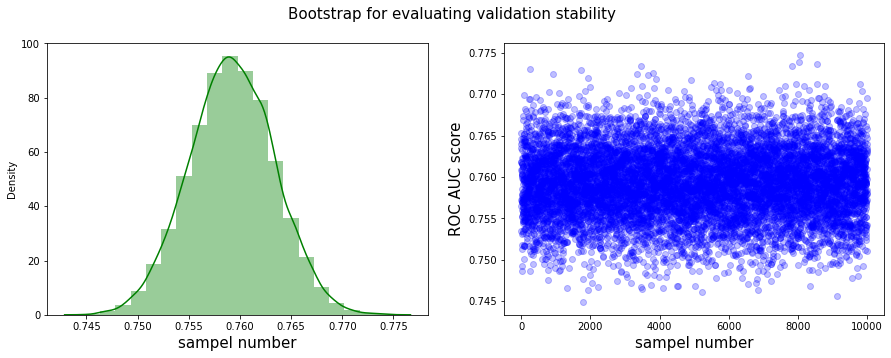

In [39]:
plot_validation(scores)

In [40]:
#scores = create_bootstrap_metrics(y_valid, model_1.predict(x_valid), roc_auc_score)
#calculate_confidence_interval(scores)
#plot_validation(scores)

In [41]:
#scores = create_bootstrap_metrics(y_test, model_1.predict(x_test), roc_auc_score)
#calculate_confidence_interval(scores)
#plot_validation(scores)

In [42]:
#scores = create_bootstrap_metrics(y_leaderboard, model_1.predict(x_leaderboard), roc_auc_score)
#calculate_confidence_interval(scores)
#plot_validation(scores)

### Вывод:

Разбиение данных на 70% (train), 20% (valid) и 10% (test):
- train_size = 0.70
    
Доверительный интервал для train, на основе бутстрэп выборок:
- (0.7510943481267962, 0.7673024788466506)

Качество на ЛБ:
- leaderboard_score=0.6161438007400407
    
leaderboard_score лежит за пределами доверительного интервала.


## Задание 4:<a class="anchor" id="task4"></a>

Выполнить Adversarial Validation (Состязательная проверка), подобрать объекты из обучающей выборки, которые сильно похожи на объекты из assignment_2_test.csv, и использовать их в качестве валидационного набора. Оценить качество модели на ЛБ, сделать выводы о полученных результатах.

In [166]:
from sklearn.metrics import roc_auc_score

In [167]:
df_train_new.head(2)
df_train_adv = df_train_new.drop(["TransactionID", "isFraud"], axis=1)

In [168]:
print(df_train_adv.shape)
df_train_adv.head(2)

(180000, 392)


,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,ProductCD_le,card4_le,card6_le,P_emaildomain_le,R_emaildomain_le,M1_le,M2_le,M3_le,M4_le,M5_le,M6_le,M7_le,M8_le,M9_le
0,86400,68.5,13926,NaN,150.0,142.0,315.0,87.0,19.0,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,2,2,0,0,1,1,1,2,0,1,2,2,2
1,86401,29.0,2755,404.0,150.0,102.0,325.0,87.0,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [169]:
print(x_leaderboard.shape)
x_leaderboard.head(2)

(100001, 392)


,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,ProductCD_le,card4_le,card6_le,P_emaildomain_le,R_emaildomain_le,M1_le,M2_le,M3_le,M4_le,M5_le,M6_le,M7_le,M8_le,M9_le
0,7415038,226.0,12473,555.0,150.0,226.0,299.0,87.0,116.0,NaN,2.0,3.0,0.0,0.0,0.0,5.0,0.0,0.0,3.0,0.0,3.0,2.0,6.0,2.0,4.0,4.0,0.0,4.0,3.0,NaN,NaN,NaN,NaN,4.0,4.0,NaN,NaN,NaN,3.0,1.0,2.0,2.0,1.0,3.0,1.0,1.0,1.0,2.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,2.0,5.0,0.0,0.0,1.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,2.0,0.0,0.0,0.0,1.0,1.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,2.0,5.0,0.0,0.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,7.0,7.0,0.0,1.0,1.0,2.0,6.0,6.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,452.0,1482.0,1482.0,0.0,206.0,206.0,452.0,1276.0,1276.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,14.0,7.0,9.0,15.0,0.0,2.0,0.0,2.0,1.0,2.0,1.0,2.0,2.0,2.0,12.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,452.000000,2924.000000,2924.000000,0.0,412.0,0.0,412.0,206.0,412.0,412.0,452.0,2512.0,2512.0,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,4,2,3,0,1,1,0,0,1,0,0,0,1
1,7415054,3072.0,15651,417.0,150.0,226.0,330.0,87.0,NaN,NaN,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1

In [195]:
# Объединяем train (assignment_2_train.csv) и leaderboard (assignment_2_test.csv) выборки
x_adv = pd.concat([
    df_train_adv, x_leaderboard], axis=0
)
# Объявляем target = 0, если объект из leaderboard-а и target=1 если объект из train
y_adv = np.hstack((np.zeros(df_train_adv.shape[0]), np.ones(x_leaderboard.shape[0])))
assert x_adv.shape[0] == y_adv.shape[0]  # проверять предположение о значениях данных
print(x_adv.shape[0])
print(y_adv.shape[0])

280001
280001


In [196]:
y_adv

array([0., 0., 0., ..., 1., 1., 1.])

In [197]:
print(x_adv.shape)
x_adv.head(2)

(280001, 392)


,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,ProductCD_le,card4_le,card6_le,P_emaildomain_le,R_emaildomain_le,M1_le,M2_le,M3_le,M4_le,M5_le,M6_le,M7_le,M8_le,M9_le
0,86400,68.5,13926,NaN,150.0,142.0,315.0,87.0,19.0,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,2,2,0,0,1,1,1,2,0,1,2,2,2
1,86401,29.0,2755,404.0,150.0,102.0,325.0,87.0,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [199]:
if 'TransactionID' in numerical_features:
    numerical_features.remove('TransactionID') 
if 'isFraud' in numerical_features:
    numerical_features.remove('isFraud') 
# Обучаем любой классификатор, обязательно с метрикой roc_auc
model_xgb = xgb.XGBClassifier(n_estimators=25)
model_xgb.fit(x_adv[numerical_features], y_adv)

[18:23:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=25, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [200]:
# Обучаем любой классификатор, обязательно с метрикой roc_auc
y_pred_adv = model_xgb.predict_proba(x_adv[numerical_features])
score = roc_auc_score(y_adv, y_pred_adv[:, 1])
print(round(score, 4))

1.0


Модель идеально разделяет данные на две выборки, т. е. данные test и train (leaderbord) не похожи др. на друга?

Записей похожих на объекты из assignment_2_test.csv нет

In [202]:
# Мы можем сделать прогнозы на обучающую часть на исходную выборку x_train 
# и от этой выборки отобрать наблюдения с большой вероятностью
y_pred = model_xgb.predict_proba(df_train_adv[numerical_features])
y_pred

array([[9.997488e-01, 2.511662e-04],
       [9.997488e-01, 2.511662e-04],
       [9.997488e-01, 2.511662e-04],
       ...,
       [9.997488e-01, 2.511662e-04],
       [9.997488e-01, 2.511662e-04],
       [9.997488e-01, 2.511662e-04]], dtype=float32)

In [205]:
# Отбираем наблюдения с большой вероятностью
# Из общей выборки выбираем наблюдения которые очень сильно похожи на тестовую выборку
# и их использования для теста, то что осталось для крос-валидации
# тогда у нас осталась бы честная оценка.
# С одной стороны у нас крос-валидация на объектах train-а, с другой стороны у нас Hold-Out валидацияъ
# еа тех объектах которые очень сильно похожи на test.
pd.cut(
    y_pred[:, 1], bins=np.arange(0, 1.01, 0.1)
).value_counts().sort_index()

(0.0, 0.1]    180000
(0.1, 0.2]         0
(0.2, 0.3]         0
(0.3, 0.4]         0
(0.4, 0.5]         0
(0.5, 0.6]         0
(0.6, 0.7]         0
(0.7, 0.8]         0
(0.8, 0.9]         0
(0.9, 1.0]         0
dtype: int64

In [228]:
if 'TransactionID' in numerical_features:
    numerical_features.remove('TransactionID') 
if 'isFraud' in numerical_features:
    numerical_features.remove('isFraud') 

x_train_adv, x_test_adv = train_test_split(
    x_adv[numerical_features], train_size=0.70, shuffle=True, random_state=1,
)

y_train_adv, y_test_adv = train_test_split(
    y_adv, train_size=0.70, shuffle=True, random_state=1,
)

In [229]:

# Обучаем любой классификатор, обязательно с метрикой roc_auc
model_lgb = lgb.LGBMClassifier(**params)
model_lgb.fit(
    X=x_train_adv[numerical_features],
    y=y_train_adv,
    eval_set=[(x_train_adv[numerical_features], y_train_adv), (x_test_adv[numerical_features], y_test_adv)],
    #categorical_feature = catigorical_features_name,
    early_stopping_rounds=25,
    eval_metric="auc",
    verbose=500
)

Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.999813	valid_1's auc: 0.999787


LGBMClassifier(learning_rate=0.01, max_depth=4, metric='auc',
               n_estimators=20000, n_jobs=6, objective='binary', reg_lambda=100,
               seed=27)

In [230]:
# Обучаем любой классификатор, обязательно с метрикой roc_auc
y_pred_adv = model_lgb.predict_proba(x_adv[numerical_features])
score = roc_auc_score(y_adv, y_pred_adv[:, 1])
print(round(score, 4))

0.9998


In [231]:
# Мы можем сделать прогнозы на обучающую часть на исходную выборку x_train 
# и от этой выборки отобрать наблюдения с большой вероятностью
y_pred = model_lgb.predict_proba(df_train_new[numerical_features])
y_pred

array([[0.64581735, 0.35418265],
       [0.64581735, 0.35418265],
       [0.64581735, 0.35418265],
       ...,
       [0.63585899, 0.36414101],
       [0.63585899, 0.36414101],
       [0.63585899, 0.36414101]])

In [232]:
# Отбираем наблюдения с большой вероятностью
# Из общей выборки выбираем наблюдения которые очень сильно похожи на тестовую выборку
# и их использования для теста, то что осталось для крос-валидации
# тогда у нас осталась бы честная оценка.
# С одной стороны у нас крос-валидация на объектах train-а, с другой стороны у нас Hold-Out валидацияъ
# еа тех объектах которые очень сильно похожи на test.
pd.cut(
    y_pred[:, 1], bins=np.arange(0, 1.01, 0.1)
).value_counts().sort_index()

(0.0, 0.1]         0
(0.1, 0.2]         0
(0.2, 0.3]         0
(0.3, 0.4]    180000
(0.4, 0.5]         0
(0.5, 0.6]         0
(0.6, 0.7]         0
(0.7, 0.8]         0
(0.8, 0.9]         0
(0.9, 1.0]         0
dtype: int64

## Задание 5:<a class="anchor" id="task5"></a>

Сделать KFold / StratifiedKFold валидацию (на ваше усмотрение), оценить получаемые качество и разброс по метрике качества. Сделать выводы об устойчивости кросс-валидации, сходимости оценки на кросс-валидации и отложенном наборе данных. Оценить качество на ЛБ, сделать выводы.

In [234]:
df_train_new.head(2)

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,ProductCD_le,card4_le,card6_le,P_emaildomain_le,R_emaildomain_le,M1_le,M2_le,M3_le,M4_le,M5_le,M6_le,M7_le,M8_le,M9_le
0,2987000,0,86400,68.5,13926,NaN,150.0,142.0,315.0,87.0,19.0,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,2,2,0,0,1,1,1,2,0,1,2,2,2
1,2987001,0,86401,29.0,2755,404.0,150.0,102.0,325.0,87.0,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.

In [235]:
data = []
data = df_train_new
x_test=df_train_new.drop(["TransactionID", "isFraud"], axis=1)
y_test=df_train_new["isFraud"]

cv = cross_val_score(
    estimator=model,
    #X=data[numerical_features],
    X=x_test,
    y=y_test,
    scoring="roc_auc",
    cv=5  # число фолдов
)

print(f"CV-results: {round(np.mean(cv), 4)} +/- {round(np.std(cv), 3)}")

CV-results: 0.8447 +/- 0.082


In [236]:
def make_cross_validation(X: pd.DataFrame,
                          y: pd.Series,
                          estimator: object,
                          metric: callable,
                          cv_strategy):
    """
    Кросс-валидация.

    Parameters
    ----------
    X: pd.DataFrame
        Матрица признаков.

    y: pd.Series
        Вектор целевой переменной.

    estimator: callable
        Объект модели для обучения.

    metric: callable
        Метрика для оценки качества решения.
        Ожидается, что на вход будет передана функция,
        которая принимает 2 аргумента: y_true, y_pred.

    cv_strategy: cross-validation generator
        Объект для описания стратегии кросс-валидации.
        Ожидается, что на вход будет передан объект типа
        KFold или StratifiedKFold.

    Returns
    -------
    oof_score: float
        Значение метрики качества на OOF-прогнозах (outo fold прогнозы).

    fold_train_scores: List[float]
        Значение метрики качества на каждом обучающем датасете кросс-валидации.

    fold_valid_scores: List[float]
        Значение метрики качества на каждом валидационном датасете кросс-валидации.

    oof_predictions: np.array
        Прогнозы на OOF.

    """
    estimators, fold_train_scores, fold_valid_scores = [], [], []
    oof_predictions = np.zeros(X.shape[0])

    for fold_number, (train_idx, valid_idx) in enumerate(cv_strategy.split(X, y)):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y.loc[train_idx], y.loc[valid_idx]

        estimator.fit(x_train, y_train)
        y_train_pred = estimator.predict(x_train)
        y_valid_pred = estimator.predict(x_valid)

        fold_train_scores.append(metric(y_train, y_train_pred))
        fold_valid_scores.append(metric(y_valid, y_valid_pred))
        oof_predictions[valid_idx] = y_valid_pred

        msg = (
            f"Fold: {fold_number+1}, train-observations = {len(train_idx)}, "
            f"valid-observations = {len(valid_idx)}\n"
            f"train-score = {round(fold_train_scores[fold_number], 4)}, "
            f"valid-score = {round(fold_valid_scores[fold_number], 4)}" 
        )
        print(msg)
        print("="*69)
        estimators.append(estimator)

    oof_score = metric(y, oof_predictions)
    print(f"CV-results train: {round(np.mean(fold_train_scores), 4)} +/- {round(np.std(fold_train_scores), 3)}")
    print(f"CV-results valid: {round(np.mean(fold_valid_scores), 4)} +/- {round(np.std(fold_valid_scores), 3)}")
    print(f"OOF-score = {round(oof_score, 4)}")

    return estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions

In [242]:
from sklearn.model_selection import KFold

In [254]:
#cv_strategy = KFold(n_splits=5, random_state=1)
cv_strategy = KFold(n_splits=5, random_state=42, shuffle=True)

In [247]:
#estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions = make_cross_validation(
#    data[numerical_features], data["y"], model, metric=r2_score, cv_strategy=cv_strategy)

estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions = make_cross_validation(
    x_test, y_test, model, metric=roc_auc_score, cv_strategy=cv_strategy
)

Fold: 1, train-observations = 144000, valid-observations = 36000
train-score = 0.7998, valid-score = 0.7446
Fold: 2, train-observations = 144000, valid-observations = 36000
train-score = 0.799, valid-score = 0.7618
Fold: 3, train-observations = 144000, valid-observations = 36000
train-score = 0.7985, valid-score = 0.753
Fold: 4, train-observations = 144000, valid-observations = 36000
train-score = 0.8005, valid-score = 0.7517
Fold: 5, train-observations = 144000, valid-observations = 36000
train-score = 0.7994, valid-score = 0.7565
CV-results train: 0.7994 +/- 0.001
CV-results valid: 0.7535 +/- 0.006
OOF-score = 0.7536


In [248]:
estimators

[LGBMClassifier(learning_rate=0.01, max_depth=4, metric='auc',
                n_estimators=20000, n_jobs=6, objective='binary', reg_lambda=100,
                seed=27),
 LGBMClassifier(learning_rate=0.01, max_depth=4, metric='auc',
                n_estimators=20000, n_jobs=6, objective='binary', reg_lambda=100,
                seed=27),
 LGBMClassifier(learning_rate=0.01, max_depth=4, metric='auc',
                n_estimators=20000, n_jobs=6, objective='binary', reg_lambda=100,
                seed=27),
 LGBMClassifier(learning_rate=0.01, max_depth=4, metric='auc',
                n_estimators=20000, n_jobs=6, objective='binary', reg_lambda=100,
                seed=27),
 LGBMClassifier(learning_rate=0.01, max_depth=4, metric='auc',
                n_estimators=20000, n_jobs=6, objective='binary', reg_lambda=100,
                seed=27)]

In [249]:
oof_score

0.7536473672795632

In [250]:
fold_train_scores

[0.7998046639171603,
 0.7990066316532937,
 0.7984615016507928,
 0.8004525389375149,
 0.7994139279258937]

In [251]:
fold_valid_scores

[0.7445990296803654,
 0.761833065681327,
 0.7530236150637785,
 0.751668088369442,
 0.7564774518252644]

In [252]:
oof_predictions

array([0., 0., 0., ..., 0., 0., 0.])